# Documentation

**Notebook Prerequisites:** This notebook relies upon the datasets created in the preparation and modelling phases.

<br>

**Notebook Comments:** Code blocks that generate new models or results have been toggled off with Boolean checks by default.

Random seeds have been set in order to promote result reproducibility, although factors such as library versions and GPU use can introduce degrees of non-determinism.

<br>

**Evaluation Overview:**
* 1.0 Configuration
* 2.0 Data Preparation
* 3.0 Classifier Testing
* 4.0 Results Analysis

<br>

**Note:** The project cells are intended to be run sequentially in Google Colab. Coding adjustments will be needed to use the code in other environments or to employ non-standard paths through the presented cell order.

# 1.0 Configuration

### | 1.1 Imports and Settings

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import shutil
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### | 1.2 Model Functions

In [ ]:
# classifier code:

# train classifier and retrieve key metrics
def retrieve_metrics(classifier, X_train, y_train, X_test, y_test):

    # train the passed classifier and test
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:, 1]  # positive probability

    # calculate set metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auprc = average_precision_score(y_test, y_prob)  # adjusted for binary class

    return {"Precision": precision, "Recall": recall, "F1": f1, "AUPRC": auprc}


# result data handling code:

# save classifier outputs with optional backup
def save_results(result_data, result_path, backup_path=None):

    # back up data if it exists
    if os.path.exists(result_path) and backup_path:
        shutil.copy(result_path, backup_path)

    # store results in dataframe and enforce column order
    results_frame = pd.DataFrame(result_data)
    ordered_columns = ['Classifier', 'Data', 'Precision', 'Recall', 'F1', 'AUPRC']
    results_frame = results_frame[ordered_columns]

    # save results to file
    results_frame.to_pickle(result_path)

# load data from pickle file
def load_pickle(result_path):

    # load into dataframe
    data = pd.read_pickle(result_path)

    return data

### | 1.3 Visualisation Functions

In [ ]:
# graph consistency functions:

# use a consistent graph style with an optional legend
def apply_style(ax, title, xlabel, ylabel, legend=False, colourbar=False):

    # base colours
    grey_bg = '#f5f5f5'
    grey_grid = '#dadada'
    grey_borders = '#282828'

    # retrieve font sizes
    medium, large = font_size()

    # label formatting
    ax.set_title(title, fontsize=large, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=medium, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=medium, fontweight="bold")

    # x tick label formatting
    for label in ax.get_xticklabels():
        label.set_fontsize(medium)

    # y tick label formatting
    for label in ax.get_yticklabels():
        label.set_fontsize(medium)

    # optional legend formatting
    if legend == True:
        graph_legend = ax.legend(loc='upper right')
        frame = graph_legend.get_frame()
        for text in graph_legend.get_texts():
            text.set_fontsize(medium)

    # optional colorbar font size to match style
    if colourbar == True:
        cbar = ax.collections[0].colorbar
        for label in cbar.ax.yaxis.get_ticklabels():
            label.set_fontsize(medium)

    # graph appearance
    ax.grid(color=grey_grid, which="both")
    ax.set_facecolor(grey_bg)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_edgecolor(grey_borders)

    # minimise overlaps
    plt.tight_layout()

# return consistent visualisation colours
def data_colours():

    # sequentially visually equidistant colour scheme
    colour_one = '#ffa600'    # yellow
    # colour_two = '#dc0062'  # pink unsued
    colour_three = '#002E6E'  # blue

    return colour_one, colour_three

# return consistent font sizes
def font_size():

    medium = 9  # intended for labels
    large = 10  # intended for titles

    return medium, large


# graph plotting functions:

def plot_bar(data, ax, title, xlabel, ylabel, log_scale=False, ylimit=None):
    colours = list(data_colours())

    # Create the graph on the subplot
    ax.bar(data.keys(), data.values(), color=colours[0], log=log_scale)

    # set y-axis limit to 6
    if ylimit != None:
        ax.set_ylim(0, ylimit)

    # Apply the defined style
    apply_style(ax, title, xlabel, ylabel)

# scale plot size to number of graphs
def plot_size(rows, columns):

    # reasonable display size for a single graph
    width = 5.5
    height = 4.5

    # scaling factor
    scaling = 0.55

    # increase plot size if multiple graphs
    horizontal = ((width * scaling) * (columns - 1)) + width
    vertical = ((height * scaling) * (rows - 1)) + height

    # inverted output order to match plotting function inputs
    return horizontal, vertical

### | 1.4 Data Loading

In [ ]:
# data loading code:

# mount google drive and provide project root
drive.mount('/content/drive/', force_remount=True)
drive_prefix = '/content/drive/MyDrive/Credit Card Synthetic Data/'

# load augmented training data
X_augmented = load_pickle(drive_prefix + 'data/augmented/X_augmented.pkl')
y_augmented = load_pickle(drive_prefix + 'data/augmented/y_augmented.pkl')

# load processed training data
X_train = load_pickle(drive_prefix + 'data/processed/X_train.pkl')
y_train = load_pickle(drive_prefix + 'data/processed/y_train.pkl')

# load processed test data
X_test = load_pickle(drive_prefix + 'data/processed/X_test.pkl')
y_test = load_pickle(drive_prefix + 'data/processed/y_test.pkl')

# force display of all dataframe columns to aid inspection
pd.set_option("display.max_columns", None)

Mounted at /content/drive/


### | 1.5 Reproducibility

In [ ]:
# random seed code:

# base and derived random seeds
random_seed = 42
random.seed(random_seed)     # for python based calculations
np.random.seed(random_seed)  # for numpy based calculations

# 2.0 Data Preparation

### | 2.1 Data Integrity Check

In [ ]:
print(f'Augmented Data Counts:\tX:{X_augmented.shape}\tY:({y_augmented.shape[0]})')
print(f'Training Data Counts:\tX:{X_train.shape}\tY:({y_train.shape[0]})')
print(f'Test Data Counts:\tX:{X_test.shape}\tY:({y_test.shape[0]})')

Augmented Data Counts:	X:(214585, 30)	Y:(214585)
Training Data Counts:	X:(212808, 30)	Y:(212808)
Test Data Counts:	X:(70937, 30)	Y:(70937)


# 3.0 Classifier Testing

### | 3.1 Classifier Data

In [ ]:
# datasets for classifier loops
training_data = {"Processed": (X_train, y_train),
            "Augmented": (X_augmented, y_augmented)}


# classifier result paths:

# root result path
result_path = drive_prefix + 'data/results/'

# decision trees paths
dt_results = result_path + 'dt_results.pkl'
dt_backup = result_path + 'backup/dt_results backup.pkl'

# knn paths
knn_results = result_path + 'knn_results.pkl'
knn_backup = result_path + 'backup/knn_results backup.pkl'

# logistic regression paths
lr_results = result_path + 'lr_results.pkl'
lr_backup = result_path + 'backup/lr_results backup.pkl'

# naive bayes paths
nb_results = result_path + 'nb_results.pkl'
nb_backup = result_path + 'backup/nb_results backup.pkl'

# random forest paths
rf_results = result_path + 'rf_results.pkl'
rf_backup = result_path + 'backup/rf_results backup.pkl'

# support vector machine paths
svm_results = result_path + 'svm_results.pkl'
svm_backup = result_path + 'backup/svm_results backup.pkl'

# list of all classifier result paths
classifier_results = [dt_results,
                      knn_results,
                      lr_results,
                      nb_results,
                      rf_results,
                      svm_results]

### | 3.2 Decision Trees

In [ ]:
# set to true to run cycle and overwrite existing backups
dt_test = False
#dt_test = True

if dt_test == True:


    # classifier metrics code:

    # list to hold metric data
    dt_metrics = []

    # instantiate classifier for all dictionary datasets
    for dataset_name, (X, y) in training_data.items():
        dt = DecisionTreeClassifier(random_state=random_seed)

        # retrieve metrics and add to list
        metrics = retrieve_metrics(dt, X, y, X_test, y_test)
        metrics["Classifier"] = "Decision Tree"
        metrics["Data"] = dataset_name
        dt_metrics.append(metrics)

    # save data to pickle file
    save_results(dt_metrics, dt_results, dt_backup)

In [ ]:
load_pickle(dt_results)

,Classifier,Data,Precision,Recall,F1,AUPRC
0,Decision Tree,Processed,0.666667,0.634146,0.650000,0.423399
1,Decision Tree,Augmented,0.714286,0.650407,0.680851,0.465182


### | 3.3 K Nearest Neighbours

In [ ]:
# set to true to run cycle and overwrite existing backups
knn_test = False
#knn_test = True

if knn_test == True:


    # classifier metrics code:

    # list to hold metric data
    knn_metrics = []

    # instantiate classifier for all dictionary datasets
    for dataset_name, (X, y) in training_data.items():
        knn = KNeighborsClassifier()  # no inherent randomness to control

        # retrieve metrics and add to list
        metrics = retrieve_metrics(knn, X, y, X_test, y_test)
        metrics["Classifier"] = "KNN"
        metrics["Data"] = dataset_name
        knn_metrics.append(metrics)

    # save data to pickle file
    save_results(knn_metrics, knn_results, knn_backup)

In [ ]:
load_pickle(knn_results)

,Classifier,Data,Precision,Recall,F1,AUPRC
0,KNN,Processed,0.941176,0.650407,0.769231,0.706354
1,KNN,Augmented,0.931818,0.666667,0.777251,0.686787


### | 3.4 Logistic Regression

In [ ]:
# set to true to run cycle and overwrite existing backups
lr_test = False
#lr_test = True

if lr_test == True:


    # classifier metrics code:

    # list to hold metric data for logistic regression
    lr_metrics = []

    # instantiate classifier for all dictionary datasets
    for dataset_name, (X, y) in training_data.items():
        lr = LogisticRegression(max_iter=10000, random_state=random_seed)

        # retrieve metrics and add to list
        metrics = retrieve_metrics(lr, X, y, X_test, y_test)
        metrics["Classifier"] = "Logistic Regression"
        metrics["Data"] = dataset_name
        lr_metrics.append(metrics)

    # save data to pickle file
    save_results(lr_metrics, lr_results, lr_backup)

In [ ]:
load_pickle(lr_results)

,Classifier,Data,Precision,Recall,F1,AUPRC
0,Logistic Regression,Processed,0.826667,0.504065,0.626263,0.650743
1,Logistic Regression,Augmented,0.842697,0.609756,0.707547,0.552785


### | 3.5 Naive Bayes



In [ ]:
# set to true to run cycle and overwrite existing backups
nb_test = False
#nb_test = True

if nb_test == True:


    # classifier metrics code:

    # list to hold metric data for naive bayes
    nb_metrics = []

    # instantiate classifier for all dictionary datasets
    for dataset_name, (X, y) in training_data.items():
        naive_bayes = GaussianNB()  # no inherent randomness to control

        # retrieve metrics and add to list
        metrics = retrieve_metrics(naive_bayes, X, y, X_test, y_test)
        metrics["Classifier"] = "Naive Bayes"
        metrics["Data"] = dataset_name
        nb_metrics.append(metrics)

    # save data to pickle file
    save_results(nb_metrics, nb_results, nb_backup)

In [ ]:
load_pickle(nb_results)

,Classifier,Data,Precision,Recall,F1,AUPRC
0,Naive Bayes,Processed,0.056180,0.731707,0.104348,0.068271
1,Naive Bayes,Augmented,0.058016,0.756098,0.107764,0.077384


### | 3.6 Random Forest

In [ ]:
# set to true to run cycle and overwrite existing backups
rf_test = False
#rf_test = True

if rf_test == True:


    # classifier metrics code:

    # list to hold metric data for random forest
    rf_metrics = []

    # instantiate classifier for all dictionary datasets
    for dataset_name, (X, y) in training_data.items():
        rf = RandomForestClassifier(n_estimators=100, random_state=random_seed)

        # retrieve metrics and add to list
        metrics = retrieve_metrics(rf, X, y, X_test, y_test)
        metrics["Classifier"] = "RandomForest"
        metrics["Data"] = dataset_name
        rf_metrics.append(metrics)

    # save data to pickle file
    save_results(rf_metrics, rf_results, rf_backup)

In [ ]:
load_pickle(rf_results)

,Classifier,Data,Precision,Recall,F1,AUPRC
0,RandomForest,Processed,0.943820,0.682927,0.792453,0.723687
1,RandomForest,Augmented,0.914894,0.699187,0.792627,0.739571


### | 3.7 Support Vector Machine

In [ ]:
# set to true to run cycle and overwrite existing backups
svm_test = False
#svm_test = True

if svm_test == True:


    # classifier metrics code:

    # list to hold metric data
    svm_metrics = []

    # instantiate classifier for all dictionary datasets
    for dataset_name, (X, y) in training_data.items():
        svm = SVC(probability=True, random_state=random_seed)

        # retrieve metrics and add to list
        metrics = retrieve_metrics(svm, X, y, X_test, y_test)
        metrics["Classifier"] = "SVM"
        metrics["Data"] = dataset_name
        svm_metrics.append(metrics)

    # save data to pickle file
    save_results(svm_metrics, svm_results, svm_backup)

In [ ]:
load_pickle(svm_results)

,Classifier,Data,Precision,Recall,F1,AUPRC
0,SVM,Processed,0.955882,0.528455,0.680628,0.691771
1,SVM,Augmented,0.924051,0.593496,0.722772,0.693068


# 4.0 Results Analysis

In [ ]:
# load all result data and concatenate along rows
result_load = [load_pickle(file_path) for file_path in classifier_results]
all_results = pd.concat(result_load, axis=0)
all_results

,Classifier,Data,Precision,Recall,F1,AUPRC
0,Decision Tree,Processed,0.666667,0.634146,0.650000,0.423399
1,Decision Tree,Augmented,0.714286,0.650407,0.680851,0.465182
0,KNN,Processed,0.941176,0.650407,0.769231,0.706354
1,KNN,Augmented,0.931818,0.666667,0.777251,0.686787
0,Logistic Regression,Processed,0.826667,0.504065,0.626263,0.650743
1,Logistic Regression,Augmented,0.842697,0.609756,0.707547,0.552785
0,Naive Bayes,Processed,0.056180,0.731707,0.104348,0.068271
1,Naive Bayes,Augmented,0.058016,0.756098,0.107764,0.077384
0,RandomForest,Processed,0.943820,0.682927,0.792453,0.723687
1,RandomForest,Augmented,0.914894,0.699187,0.792627,0.739571


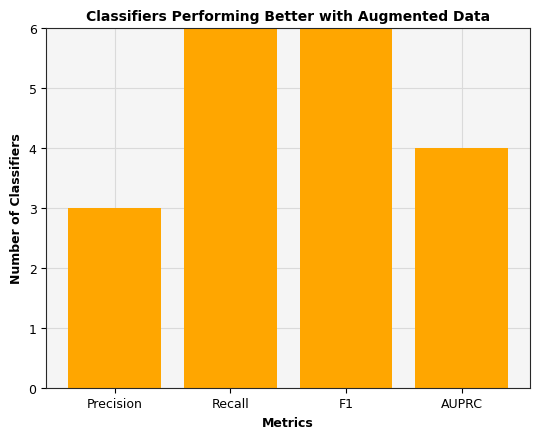

In [ ]:
# improvement evaluation code:

# dictionary to store the metric counts
better_with_augmented = {'Precision': 0, 'Recall': 0, 'F1': 0, 'AUPRC': 0}

# populate list of unique classifiers
classifiers = all_results['Classifier'].unique()

# iterate over classifiers and compare the metric performance
for classifier in classifiers:
    processed_data = all_results[(all_results['Classifier'] == classifier) & (all_results['Data'] == 'Processed')]
    augmented_data = all_results[(all_results['Classifier'] == classifier) & (all_results['Data'] == 'Augmented')]

    for metric in better_with_augmented.keys():
        if augmented_data[metric].values[0] > processed_data[metric].values[0]:
            better_with_augmented[metric] += 1


# visualisation code:

# plot results
fig, ax = plt.subplots(figsize=(plot_size(1,1)))
plot_bar(better_with_augmented, ax, "Classifiers Performing Better with Augmented Data", "Metrics", "Number of Classifiers", ylimit=6)
plt.show()